In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import spacy, stanza
import langid


In [2]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Charge un fichier CSV et le retourne sous forme de DataFrame

    Parameters:
    filepath (str): Le chemin du fichier CSV à charger

    Returns:
    pd.DataFrame: Le DataFrame contenant les données du fichier CSV
    """
    return pd.read_csv(filepath)

def analyze_language_distribution(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la distribution des langues dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La distribution des langues
    """
    return data['Label'].value_counts()


In [3]:
data = load_data('../../data/csv/data.csv')
print(analyze_language_distribution(data))

Label
en    667
ru    615
de    535
es    417
fr    416
ja    283
zh    270
ko    268
ar     74
Name: count, dtype: int64


Chaque ligne montre une langue représentée par son code (par exemple, "en" pour l'anglais, "ru" pour le russe, etc.) suivi du nombre de ligne en cette langue présents dans le corpus. Voici une description plus détaillée de ces résultats :

- **Anglais (en)** : Le corpus contient 667 textes en anglais, ce qui en fait la langue la plus représentée.
- **Russe (ru)** : Il y a 615 textes en russe, plaçant cette langue en deuxième position en termes de fréquence dans le corpus.
- **Allemand (de)** : L'allemand suit avec 535 textes.
- **Espagnol (es)** : L'espagnol compte 417 textes.
- **Français (fr)** : Très proche de l'espagnol, le français est représenté par 416 textes.
- **Japonais (ja)** : Il y a 283 textes en japonais.
- **Chinois (zh)** : Le corpus inclut 270 textes en chinois.
- **Coréen (ko)** : Avec 268 textes, le coréen a une représentation similaire au chinois.
- **Arabe (ar)** : L'arabe a la plus faible représentation avec seulement 74 textes.

### Interprétations et Implications

1. **Déséquilibre dans la Distribution** : La distribution des langues montre un déséquilibre significatif. L'anglais et le russe dominent le corpus, tandis que l'arabe est nettement sous-représenté. Ce type de déséquilibre peut influencer la performance des modèles de traitement du langage naturel entraînés sur ce corpus, les rendant potentiellement moins efficaces pour les langues moins représentées.

2. **Stratégies de Rééquilibrage** : Pour des applications nécessitant une performance équilibrée à travers les différentes langues, il pourrait être nécessaire de rééquilibrer ce corpus soit par sous-échantillonnage des langues dominantes (comme l'anglais et le russe), soit par sur-échantillonnage des langues moins représentées (comme l'arabe).

3. **Considérations pour l'Analyse Multilingue** : Lors de la mise en place de modèles multilingues ou de tests d'algorithmes sur ce corpus, il sera important de tenir compte de cette distribution pour évaluer correctement leur performance et leur capacité à généraliser à travers différentes langues.


In [4]:
def analyze_text_length(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la longueur des textes dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: Les statistiques descriptives de la longueur des textes
    """
    data['Text_Length'] = data['Text'].apply(len)
    return data['Text_Length'].describe()

def plot_distributions(data: pd.DataFrame) -> None:
    """
    Affiche les distributions des langues et de la longueur des textes

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à afficher
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y='Label', order=data['Label'].value_counts().index)
    plt.title('Distribution des langues')
    plt.xlabel('Nombre de textes')
    plt.ylabel('Langue')

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x='Text_Length', bins=30)
    plt.title('Distribution de la longueur des textes')
    plt.xlabel('Longueur du texte')
    plt.ylabel('Fréquence')
    
    plt.show()

count    3545.000000
mean      208.389563
std       136.981146
min         6.000000
25%       112.000000
50%       186.000000
75%       272.000000
max      1482.000000
Name: Text_Length, dtype: float64


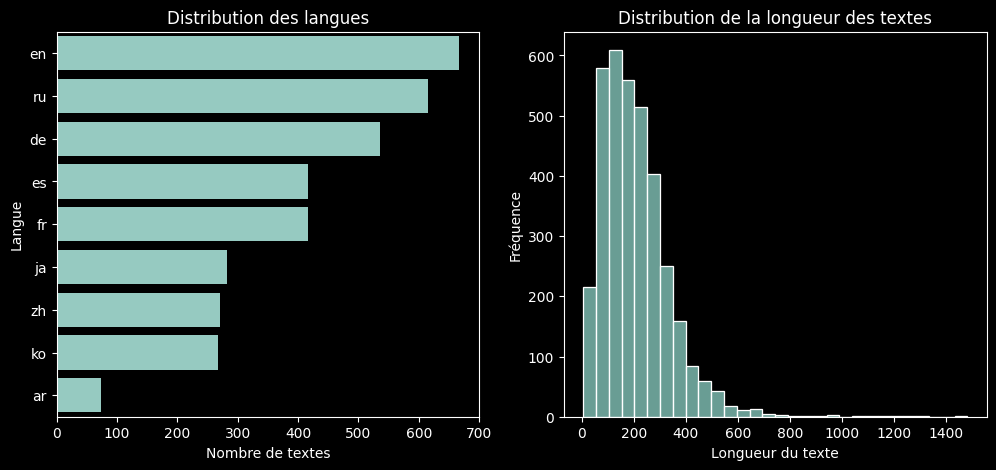

In [5]:
print(analyze_text_length(data))
plot_distributions(data)

### Analyse des Statistiques de Longueur des Textes
Voici un résumé des statistiques que vous avez fournies, illustrées sous forme de description textuelle pour mieux comprendre les implications :

- **Count**: 3545 textes ont été analysés, donnant une bonne taille d'échantillon pour des analyses statistiques robustes.
- **Mean**: La longueur moyenne des textes est de 208.39 caractères. Cela indique une tendance vers des textes plutôt courts, ce qui est normal étant donné que pour chaque ligne il y a seulement jusqu'à 2 phrases maximum.
- **Std (Standard Deviation)**: L'écart-type est de 136.98, ce qui suggère une variation considérable dans la longueur des textes.
- **Min**: Le texte le plus court fait seulement 6 caractères, ce qui pourrait être insuffisant pour certaines analyses linguistiques ou de traitement de texte.
- **25% (1st Quartile)**: 25% des textes ont 112 caractères ou moins.
- **50% (Median)**: La médiane est à 186 caractères, confirmant que la distribution est assez centrée sur des textes plus courts.
- **75% (3rd Quartile)**: 75% des textes ont 272 caractères ou moins.
- **Max**: Le texte le plus long a 1482 caractères, montrant qu'il y a quelques cas où les textes sont significativement plus longs.

### Interprétation Visuelle (Graphique)
1. **Distribution des langues** : Version graphique des resultats de la fonction `analyze_language_distribution()`.
2. **Distribution de la longueur des textes** : Cela aide à visualiser la répartition de la longueur des textes, indiquant si la plupart des textes sont uniformément courts ou s'il y a une large gamme de longueurs.


In [6]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang='ar') # Arabic

def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == 'ar':
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]

def vocabulary_diversity(data: pd.DataFrame) -> pd.Series:
    """
    Calcule la diversité du vocabulaire pour chaque langue

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La diversité du vocabulaire pour chaque langue
    """
    data['Tokens'] = data.apply(lambda row: tokenize(row['Text'], row['Label']), axis=1)
    data['Vocab_Size'] = data['Tokens'].apply(lambda x: len(set(x)))
    return data.groupby('Label')['Vocab_Size'].mean()


2024-05-05 17:00:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-05 17:00:44 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-05 17:00:45 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-05 17:00:45 INFO: Using device: cpu
2024-05-05 17:00:45 INFO: Loading: tokenize
2024-05-05 17:00:45 INFO: Loading: mwt
2024-05-05 17:00:45 INFO: Loading: pos
2024-05-05 17:00:46 INFO: Loading: lemma
2024-05-05 17:00:46 INFO: Loading: depparse
2024-05-05 17:00:46 INFO: Loading: ner
2024-05-05 17:00:46 INFO: Done loading processors!


In [7]:
vocab_diversity = vocabulary_diversity(data)
print(vocab_diversity)

Label
ar    68.702703
de    27.241121
en    37.290855
es    37.762590
fr    38.569712
ja    43.438163
ko    26.160448
ru    30.773984
zh    37.900000
Name: Vocab_Size, dtype: float64


Les résultats de la diversité du vocabulaire pour chaque langue indiqués ci-dessus montrent le nombre moyen de mots uniques par texte pour chaque langue du corpus. Ces chiffres sont cruciaux pour comprendre la variété linguistique et la richesse du contenu textuel dans un contexte de détection de la langue, surtout étant donné que chaque texte se compose de deux phrases au maximum. Voici une analyse des valeurs et de leurs implications potentielles pour la tâche de détection de la langue :

### Analyse des Résultats
- **Arabe (ar)**: Avec une moyenne de 68.70, l'arabe montre la diversité lexicale la plus élevée. Cela pourrait s'expliquer par la structure de la langue et l'usage fréquent de racines verbales et dérivations qui produisent un grand nombre de mots uniques même dans de courts textes.
- **Allemand (de)** et **Coréen (ko)**: Ces langues montrent la diversité lexicale la plus faible, avec des moyennes respectives de 27.24 et 26.16. Pour l'allemand, cela pourrait être surprenant car c'est une langue à flexion riche. Cela peut suggérer que les textes en allemand dans le corpus ne couvrent pas une gamme étendue de sujets ou utilisent un vocabulaire plus restreint.
- **Anglais (en)**, **Espagnol (es)**, **Français (fr)**, et **Chinois (zh)**: Ces langues affichent des valeurs assez proches les unes des autres, fluctuant entre 37.29 et 38.57, ce qui indique une diversité moyenne. Cela montre que les textes sont relativement diversifiés mais pas exceptionnellement variés en termes de vocabulaire.
- **Japonais (ja)**: Avec une valeur de 43.44, le japonais montre une diversité relativement élevée, ce qui pourrait être lié à l'utilisation de trois alphabets différents dans la langue, augmentant le nombre de mots uniques détectés.
- **Russe (ru)**: Avec un score de 30.77, le russe montre une diversité modérée. Comme c’est une langue slave avec une riche inflexion, cela peut suggérer une limitation dans la gamme de sujets ou de styles couverts par les textes.

### Implications pour la Détection de la Langue
- **Entraînement des Modèles** : Une diversité lexicale plus élevée peut rendre plus difficile pour les modèles de NLP de prédire correctement la langue sur des bases purement lexicales, surtout si les textes sont courts. Les modèles peuvent avoir besoin d'être sensibles à des caractéristiques linguistiques plus subtiles que de simples fréquences de mots.
- **Prétraitement et Normalisation** : Pour des langues avec une grande diversité lexicale dans de courts textes, des techniques comme la lemmatisation ou la normalisation peuvent aider à réduire la dimensionnalité et à améliorer la performance de détection de la langue.
- **Équilibrage du Corpus** : Les résultats suggèrent un besoin possible d’équilibrer le corpus non seulement en termes de nombre de textes par langue mais aussi en termes de diversité lexicale pour éviter les biais envers des langues avec une diversité naturellement plus élevée ou plus basse.

### Conclusion
Ces résultats fournissent des insights importants sur la complexité et les défis liés à la construction d'un système robuste de détection de la langue pour un corpus multilingue avec des textes courts. Ils soulignent l'importance d'une compréhension approfondie des caractéristiques linguistiques de chaque langue pour optimiser les stratégies de prétraitement et d'entraînement des modèles.

In [19]:
def detect_language(text: str) -> str:
    """ 
    Detecte la langue d'un texte

    Parameters:
    text (str): le texte à analyser

    Returns:
    str: la langue du texte
    """
    lang, _ = langid.classify(text) 
    return lang

def plot_confusion_matrix(data: pd.DataFrame) -> plt.Figure:
    """
    Matrice de confusion pour la détection de la langue des textes.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    true_labels = data['Label'].tolist()
    predictions = data['Text'].apply(detect_language)
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    return fig

def build_and_test_model(train_csv: str, test_csv: str) -> None:
    """
    Construit un modèle de classification de texte et l'évalue en utilisant des fichiers CSV d'entraînement et de test séparés.

    Parameters:
    train_csv (str): Chemin vers le fichier CSV d'entraînement.
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données d'entraînement et de test
    train_data = pd.read_csv(train_csv)
    test_data = pd.read_csv(test_csv)

    # Remplacement des valeurs NaN par des chaînes vides
    train_data['Text'] = train_data['Text'].fillna('')
    test_data['Text'] = test_data['Text'].fillna('')

    # Vectorisation des textes
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data['Text'])
    y_train = train_data['Label']
    X_test = vectorizer.transform(test_data['Text'])
    y_test = test_data['Label']

    # Construction et entraînement du modèle
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Rapport de classification
    print(classification_report(y_test, y_pred))

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, fmt='.2%', cmap='Reds', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.title('Matrice de confusion')
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')

    save_path = '../../resultats/confusion_matrix.png'
    plt.savefig(save_path)
    
    plt.show()

              precision    recall  f1-score   support

          ar       1.00      1.00      1.00        19
          de       0.99      0.99      0.99       131
          en       0.64      1.00      0.78       126
          es       0.94      1.00      0.97        76
          fr       0.99      0.97      0.98        75
          ja       1.00      0.42      0.59        53
          ko       1.00      0.93      0.96        56
          ru       0.98      1.00      0.99       123
          zh       0.90      0.18      0.30        51

    accuracy                           0.89       710
   macro avg       0.94      0.83      0.84       710
weighted avg       0.92      0.89      0.87       710



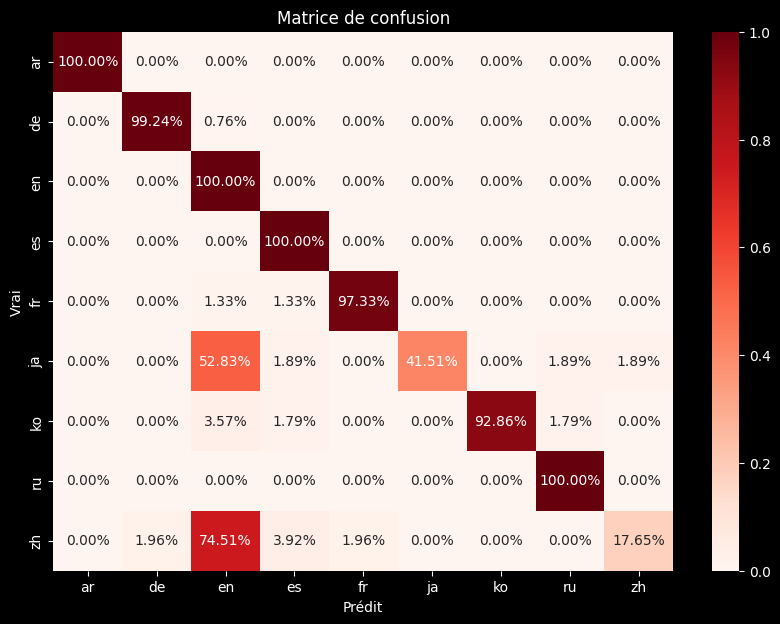

In [20]:
train_csv = '../../data/csv/data_train.csv'
test_csv = '../../data/csv/data_test.csv'

build_and_test_model(train_csv, test_csv)

La matrice de confusion que vous avez partagée visualise la performance d'un modèle de détection de langue appliqué à un corpus où chaque texte comprend jusqu'à deux phrases. Chaque cellule de la matrice représente le pourcentage de prédictions pour une langue spécifique (colonnes) en fonction de la langue réelle du texte (lignes). Un modèle parfait aurait 100 % dans toutes les cellules diagonales (vrais positifs), indiquant que chaque langue est toujours correctement identifiée.

Ici :

- **Langues à haute précision** : Certaines langues comme l'arabe (`ar`), l'allemand (`de`), l'anglais (`en`), l'espagnol (`es`), le russe (`ru`) et le coréen (`ko`) ont une très haute précision, indiquée par presque ou exactement 100 % dans leurs cellules diagonales respectives. Cela suggère que le modèle est très efficace pour identifier ces langues.

- **Langues problématiques** : Cependant, le japonais (`ja`) et le chinois (`zh`) montrent des problèmes significatifs. Par exemple, seulement 41,51 % des textes japonais sont correctement identifiés, avec une partie importante (52,83 %) mal classée comme chinois. De même, le chinois a seulement 17,65 % de classification correcte avec une notable confusion de 74,51 % comme anglais. Cette confusion entre le japonais et le chinois pourrait être due à des ensembles de caractères similaires utilisés dans des textes courts, rendant la différenciation plus difficile pour le modèle. Par contre, je ne m'explique pas pourquoi le chinois est souvent confondu avec l'anglais.

- **Précision modérée** : Le français (`fr`) montre une bonne précision mais pas parfaite, avec un petit pourcentage confondu avec l'allemand et l'anglais.

Ces résultats indiquent que, bien que le modèle fonctionne très bien pour la plupart des langues, il a des difficultés avec les langues qui partagent des caractéristiques linguistiques ou des scripts, en particulier dans des formats de texte court. Cela pourrait suggérer un besoin de données d'entraînement plus spécialisées, d'une meilleure ingénierie des caractéristiques (comme la tokenisation basée sur les caractères pour ces langues), ou des ajustements dans l'architecture du modèle pour améliorer la distinction entre ces langues.

              precision    recall  f1-score   support

          an       0.00      0.00      0.00         0
          ar       1.00      1.00      1.00        19
          da       0.00      0.00      0.00         0
          de       1.00      0.99      1.00       131
          en       0.99      0.98      0.98       126
          es       0.99      0.97      0.98        76
          fr       1.00      0.97      0.99        75
          ja       1.00      0.98      0.99        53
          ko       1.00      1.00      1.00        56
          ky       0.00      0.00      0.00         0
          la       0.00      0.00      0.00         0
          ru       1.00      0.99      1.00       123
          zh       0.98      1.00      0.99        51

    accuracy                           0.99       710
   macro avg       0.69      0.68      0.69       710
weighted avg       1.00      0.99      0.99       710



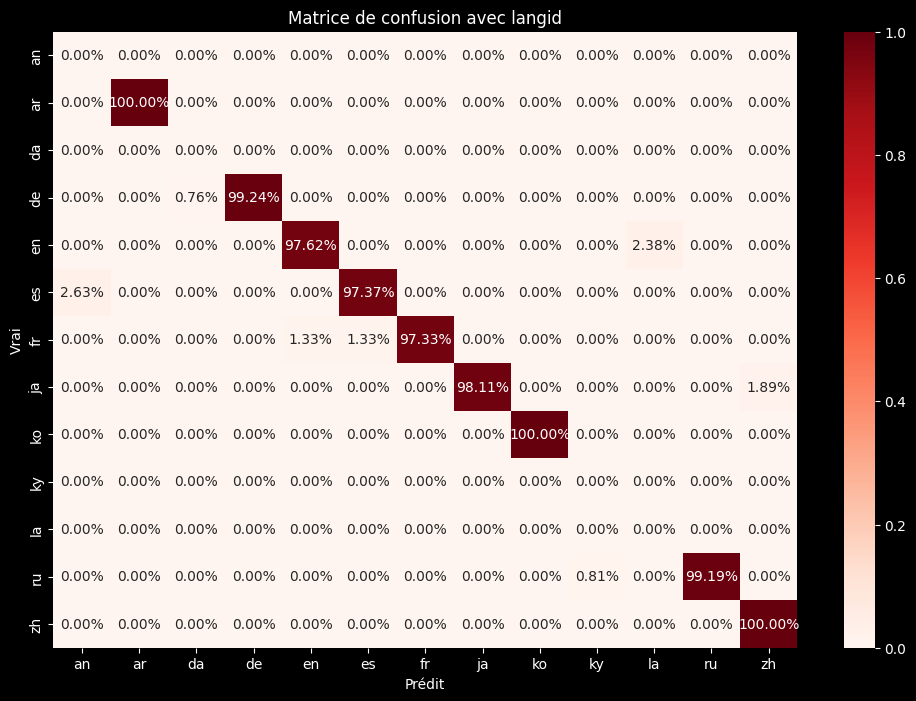

In [18]:
def build_and_test_model_with_langid(test_csv: str) -> None:
    """
    Construit un modèle de classification de texte utilisant langid pour la prédiction de la langue.
    
    Parameters:
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données de test
    test_data = pd.read_csv(test_csv)
    test_data['Text'] = test_data['Text'].fillna('')  # Remplacement des valeurs NaN par des chaînes vides

    # Prédiction des langues avec langid
    predictions = [langid.classify(text)[0] for text in test_data['Text']]
    test_data['Predicted'] = predictions

    # Obtention des ensembles de labels uniques
    unique_labels = sorted(set(test_data['Label']))
    unique_predictions = sorted(set(test_data['Predicted']))

    # Union des labels et des prédictions pour couvrir toutes les possibilités
    all_langs = sorted(set(unique_labels + unique_predictions))

    print(classification_report(test_data['Label'], test_data['Predicted'], labels=all_langs, zero_division=0))

    # Création de la matrice de confusion
    cm = confusion_matrix(test_data['Label'], test_data['Predicted'], labels=all_langs, normalize='true')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Reds', xticklabels=all_langs, yticklabels=all_langs)
    plt.title('Matrice de confusion avec langid')
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')

    save_path = '../../resultats/confusion_matrix_with_langid.png'
    plt.savefig(save_path)

    plt.show()


build_and_test_model_with_langid(test_csv)

**Observations spécifiques** :
   - Une grande précision pour des langues comme l'arabe (`ar`), l'allemand (`de`), le japonais (`ja`), le coréen (`ko`), et le chinois (`zh`), où le modèle a correctement prédit plus de 99 % des instances.
   - Certaines mauvaises classifications sont évidentes, telles que :
     - 2,63 % des textes en espagnol (`es`) ont été mal classifiés comme étant en anglais (`en`).
     - Les textes en anglais (`en`) présentent un taux de mauvaise classification de 2,38 % comme étant en japonais (`ja`).
     - Les textes en français (`fr`) ont été mal classifiés comme étant en anglais et en espagnol à 1,33 % chacun.
     - Les textes en japonais (`ja`) ont été mal classifiés comme étant en chinois (`zh`) à 1,89 %.

Cette analyse aide à identifier les langues avec lesquelles le modèle performe bien et celles où il pourrait avoir des difficultés, ce qui peut guider un ajustement ultérieur ou une collecte de données d'entraînement supplémentaires pour les langues spécifiques qui montrent des taux de mauvaise classification plus élevés.

**Comparaison des deux matrices de confusion** :
Comparons les résultats des deux matrices de confusion pour l'identification de la langue des textes :

1. **Première matrice (ar, de, en, es, fr, ja, ko, ru, zh)**:
   - **Performances générales** : Les langues telles que l'arabe (ar), l'espagnol (es), et le russe (ru) montrent une précision de 100% dans la prédiction correcte, tandis que le japonais (ja) et le coréen (ko) présentent des erreurs significatives.
   - **Problèmes spécifiques** :
     - Le japonais (ja) est souvent confondu avec le chinois (zh) à 52.83% et avec lui-même seulement à 41.51%.
     - Le chinois (zh) est principalement confondu avec l'anglais (en) à 74.51%, alors que la prédiction avec lui-même n'est que de 17.65%.
     - Le coréen (ko) est également confondu avec le japonais (ja) à 3.57% et avec le russe (ru) à 1.79%.

2. **Deuxième matrice (an, ar, da, de, en, es, fr, ja, ko, ky, la, ru, zh)**:
   - **Performances générales** : Cette matrice montre une précision très élevée pour la plupart des langues, avec des scores de précision proches de 100% pour le chinois (zh), l'allemand (de), l'espagnol (es), et le russe (ru).
   - **Problèmes spécifiques** :
     - L'anglais (en) montre un faible taux de confusion avec l'espagnol (es) à 2.63%.
     - Le japonais (ja) montre une petite confusion avec le chinois (zh) à 1.89%.

**Comparaison et Conclusion**:
- La première matrice montre des problèmes plus significatifs de confusion entre certaines langues asiatiques, ce qui peut indiquer un problème avec la manière dont ces langues sont traitées ou identifiées par le modèle.
- La deuxième matrice, en revanche, montre des taux de précision globalement plus élevés et moins de confusion significative entre les langues, ce qui peut indiquer une meilleure performance du modèle ou une meilleure qualité des données.
- Ces différences pourraient aussi résulter de différentes méthodologies de traitement des données, de caractéristiques des ensembles de données ou de paramètres de modèle.

L'analyse de ces matrices aide à identifier les faiblesses spécifiques des modèles et à guider les améliorations futures, notamment en ajustant les méthodes de traitement des langues qui présentent des taux élevés de confusion.